### With cleaner info from html's

In [1]:
import pickle
with open('artist_docs3.pkl', 'rb') as f:
    all_tracks= pickle.load(f)
print(len(all_tracks))

210493


In [2]:
import pandas as pd
all_df = pd.DataFrame(all_tracks)
all_df.count()

artist1    210493
artist2    210493
url        210493
dtype: int64

In [5]:
import networkx as nx

G = nx.Graph()
for i in range(len(all_df)):
    
    artist1 = all_df.iloc[i]['artist1']
    artist2 = all_df.iloc[i]['artist2']
        
    if not G.has_node(artist1):
        G.add_node(artist1)
    if not G.has_node(artist2):
        G.add_node(artist2)
    if not G.has_edge(artist1,artist2):
        G.add_edge(artist1, artist2, weight=1)
    else:
        try:
            G[artist1][artist2]['weight'] += 1
        except:
            print(G[artist1][artist2])
            break

print(G.number_of_edges())
print(G.number_of_nodes())

150152
5699


In [6]:
nx.shortest_path(G, 'Lane 8', 'deadmau5', weight='weight')

['Lane 8', 'Wheats', 'deadmau5']

In [7]:
import numpy as np

weights = []
for i in range(len(all_df)):
    
    artist1 = all_df.iloc[i]['artist1']
    artist2 = all_df.iloc[i]['artist2']
    
    weights.append(G[artist1][artist2]['weight'])
    
print(np.max(weights))
print(np.mean(weights))

272
4.952169430812426


In [8]:
max_weight = np.max(weights)
print(max_weight)

272


In [9]:
pairs = []
for i in range(len(all_df)):
    
    artist1 = all_df.iloc[i]['artist1']
    artist2 = all_df.iloc[i]['artist2']
    
    pairs.append(tuple((artist1,artist2)))
    
print(len(set(pairs)))
pairs = set(pairs)

162000


In [10]:
G_new = G.copy()

new_weights = []
for pair in pairs:
    
    artist1 = pair[0]
    artist2 = pair[1]
        
    # Invert and normalize weights
    new_weights.append(1. - (G_new[artist1][artist2]['weight'] / max_weight))

    G_new[artist1][artist2]['weight'] = 1. - (G[artist1][artist2]['weight'] / float(max_weight))

In [11]:
# Shortest path Lane 8 -- deadmau5           
print(nx.shortest_path(G_new, 'Lane 8', 'deadmau5', weight='weight'))

['Lane 8', 'Wheats', 'deadmau5']


In [12]:
# Shortest path Lane 8 -- Kryder          
print(nx.shortest_path(G_new, 'Lane 8', 'Kryder', weight='weight'))

['Lane 8', 'Jochen Miller', 'David Guetta', 'Kryder']


In [13]:
# Shortest path Lane 8 -- Above & Beyond          
print(nx.shortest_path(G_new, 'Lane 8', 'ALPHA 9', weight='weight'))

['Lane 8', 'ALPHA 9']


### It definitely abuses nodes that represent artists that are probably played constantly (i.e. Pryda/Prydz)
- Weight by inverse representation of artists on both sides of edge could fix this

In [62]:
from collections import Counter

all_artists = np.append(all_df['artist1'], all_df['artist2'])
artist_weights = Counter(all_artists)

max_count = np.max(list(artist_weights.values()))
for key in artist_weights.keys():
    artist_weights[key] /= float(max_count)

In [15]:
G_weighted = G.copy()

weighted_weights  = [] #great var name
for pair in pairs:
    
    artist1 = pair[0]
    artist2 = pair[1]
        
    weighted_weights.append(\
                            (1. - (G[artist1][artist2]['weight'] / float(max_weight))) *\
                                             artist_weights[artist1] * artist_weights[artist2]
                           )

    G_weighted[artist1][artist2]['weight'] = (1. - (G[artist1][artist2]['weight'] / float(max_weight))) *\
                                             artist_weights[artist1] * artist_weights[artist2]

In [16]:
# Shortest path Lane 8 -- deadmau5 (priority to lesser known artist)     
print(nx.shortest_path(G_weighted, 'Lane 8', 'deadmau5', weight='weight'))

### FUCK YESSSSSSSS -- but not sure why we still have features getting thru...

['Lane 8', 'MSJ', 'ALPHA 9', 'Chris Simon', 'Rinzen', 'Gallya', 'deadmau5']


In [17]:
# Shortest path Lane 8 -- deadmau5 (priority to lesser known artist)     
print(nx.shortest_path(G_weighted, 'Lane 8', 'Kryder', weight='weight'))

### Dont know any of these motherfuckers

['Lane 8', 'MSJ', 'ALPHA 9', 'Cory Lasser', 'London Grammar', 'Pete Tong', 'John Monkman', 'Chosmic Chaos', 'Nick Devon', 'Mashk', 'Alberth', 'Soul Brucke', 'Marino Canal', 'Big Al', 'Zombie Nation', 'Kryder']


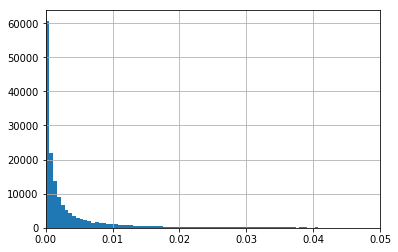

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
ax = plt.hist(weighted_weights, bins=1000)
grid = plt.grid()
xlim = plt.xlim([0,.05])

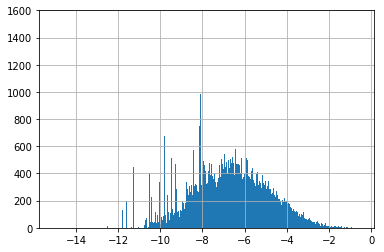

In [20]:
%matplotlib inline
ax = plt.hist([np.log(w) for w in weighted_weights if w != 0], bins=1000)
grid = plt.grid()

In [21]:
import numpy as np
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])
    
Str1 = "Lane 8"
Str2 = "Lane8"
Distance = levenshtein_ratio_and_distance(Str1,Str2)
print(Distance)
Ratio = levenshtein_ratio_and_distance(Str1,Str2,ratio_calc = True)
print(Ratio)

The strings are 1 edits away
0.9090909090909091


In [22]:
def node_match(string, graph):
    
    matches = []
    for node_name in list(graph.nodes()):
        ratio = levenshtein_ratio_and_distance(string.lower(),node_name.lower(),ratio_calc=True)
        matches.append((ratio,node_name))
        
    return sorted(matches, key=lambda x: x[0], reverse=True)[:10]

node_match('Joyryde', G_new)

[(1.0, 'JOYRYDE'),
 (0.7272727272727273, 'Jyye'),
 (0.6153846153846154, 'Jordon'),
 (0.6153846153846154, 'Kryder'),
 (0.6153846153846154, 'Jaydee'),
 (0.5714285714285714, 'Ordonez'),
 (0.5714285714285714, 'Orkidea'),
 (0.5714285714285714, 'ReOrder'),
 (0.5454545454545454, 'ODEA'),
 (0.5454545454545454, 'Royd')]

### Artist Library Clustering???
- Need to do this on the played by data

In [23]:
raw_nodes = sorted(list(artist_weights.items()), key=lambda x: x[1], reverse=True)
raw_nodes = [node[0] for node in raw_nodes]
raw_nodes = [node for node in raw_nodes if '&' not in node][:1000]
node_matrix = np.zeros((len(raw_nodes),len(raw_nodes)))
print(node_matrix.shape)

(1000, 1000)


In [63]:
#del node_matrix
raw_nodes[:20]

['Martin Garrix',
 'David Guetta',
 'Ti\\xc3\\xabsto',
 'Drake',
 'Nicky Romero',
 'Dimitri Vegas',
 'Like Mike',
 'Armin van Buuren',
 'Calvin Harris',
 'Aly',
 'Avicii',
 'Afrojack',
 'W',
 'Fila',
 'Swedish House Mafia',
 'Diplo',
 'DJ Snake',
 'Hardwell',
 'Laidback Luke',
 'Axwell']

In [25]:
for i in range(len(raw_nodes))[:]:
    for j in range(len(raw_nodes)):
        if i == j:
            node_matrix[i][j] = 0
        else:
            try:
                node_matrix[i][j] = G[raw_nodes[i]][raw_nodes[j]]['weight']
                #print(node_matrix[i][j])
            except:
                node_matrix[i][j] = 0

                
for i in range(len(raw_nodes))[:]:
    
    if np.sum(node_matrix[i,:]) == 0:
        pass
    else:
        node_matrix[i,:] /= np.sum(node_matrix[i,:])


In [27]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = TSNE(n_components=3).fit_transform(node_matrix)
#X = PCA(n_components=3).fit_transform(node_matrix)
X

array([[-28.722698 ,  -8.323324 ,  19.006777 ],
       [-52.67839  ,  -5.222483 ,  25.539328 ],
       [-48.45884  ,  -7.4495993,  33.635586 ],
       ...,
       [ 12.433115 ,  51.574917 ,  47.481236 ],
       [ 27.271015 ,  55.767315 , -46.289646 ],
       [  6.5218773,  73.702095 ,  -7.28493  ]], dtype=float32)

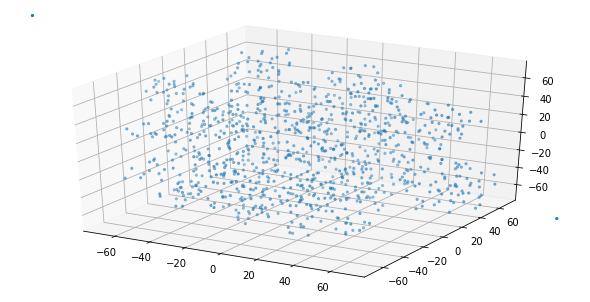

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(8,4))
ax = Axes3D(fig) 
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=5)

xlim = ax.set_xlim3d([-75,75])
ylim = ax.set_ylim3d([-75,75])
zlim = ax.set_zlim3d([-75,75])
# xlim = ax.set_xlim3d([-.03,.03])
# ylim = ax.set_ylim3d([-.03,.03])
# zlim = ax.set_zlim3d([-.03,.03])

Silhouette Coefficient 5: 0.431
Silhouette Coefficient 6: 0.429
Silhouette Coefficient 7: 0.411
Silhouette Coefficient 8: 0.415
Silhouette Coefficient 9: 0.404
Silhouette Coefficient 10: 0.406
Silhouette Coefficient 11: 0.423
Silhouette Coefficient 12: 0.421
Silhouette Coefficient 13: 0.439
Silhouette Coefficient 14: 0.436
Silhouette Coefficient 15: 0.413
Silhouette Coefficient 16: 0.420
Silhouette Coefficient 17: 0.429
Silhouette Coefficient 18: 0.437
Silhouette Coefficient 19: 0.434
Silhouette Coefficient 20: 0.430


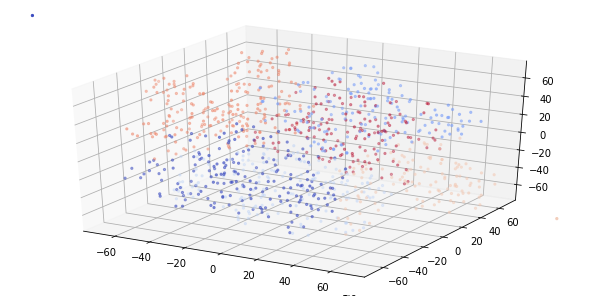

In [29]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics

for i in range(5,21):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    print("Silhouette Coefficient %d: %0.3f" % (i, metrics.silhouette_score(X, kmeans.labels_, metric='sqeuclidean')))

fig = plt.figure(figsize=(8,4))
ax = Axes3D(fig) 
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
colors = kmeans.labels_

ax = Axes3D(fig) #<-- Note the difference from your original code...
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=5, c=colors, cmap=plt.cm.coolwarm)

xlim = ax.set_xlim3d([-75,75])
ylim = ax.set_ylim3d([-75,75])
zlim = ax.set_zlim3d([-75,75])
# xlim = ax.set_xlim3d([-.03,.03])
# ylim = ax.set_ylim3d([-.03,.03])
# zlim = ax.set_zlim3d([-.03,.03])

Estimated number of clusters: 6
Silhouette Coefficient: 0.429


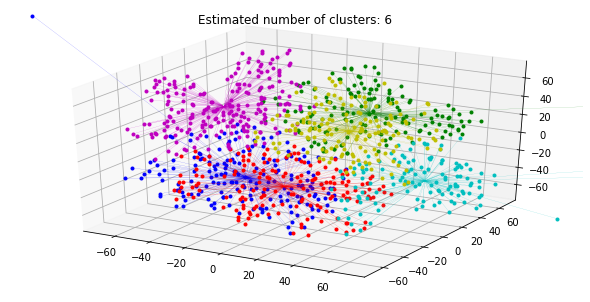

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import cycle

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

n_clusters_ = len(cluster_centers)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

fig = plt.figure(figsize=(8,4))
ax = Axes3D(fig) 

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[class_members, 0], X[class_members, 1], X[class_members, 2], col + '.')
    #plt.plot(cluster_center[0], cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,
    #         markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], [cluster_center[2], x[2]], col, linewidth=.1)

xlim = ax.set_xlim3d([-75,75])
ylim = ax.set_ylim3d([-75,75])
zlim = ax.set_zlim3d([-75,75])
# xlim = ax.set_xlim3d([-.03,.03])
# ylim = ax.set_ylim3d([-.03,.03])
# zlim = ax.set_zlim3d([-.03,.03])

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [72]:
cluster_df = pd.DataFrame([[raw_nodes[i], labels[i]] for i in range(len(raw_nodes))])
cluster_df.head(10)

,0,1
0,Martin Garrix,3
1,David Guetta,3
2,Ti\xc3\xabsto,3
3,Drake,0
4,Nicky Romero,3
5,Dimitri Vegas,3
6,Like Mike,3
7,Armin van Buuren,0
8,Calvin Harris,0
9,Aly,1


In [71]:
cluster_df[cluster_df[1] == 0].head(10)

,0,1
16,DJ Snake,0
23,Zomboy,0
34,Skrillex,0
39,SLANDER,0
44,Angerfist,0
46,Warface,0
47,Cheat Codes,0
51,GTA,0
57,Showtek,0
58,Eptic,0


In [70]:
cluster_df[cluster_df[1] == 1].head(10)

,0,1
70,QUIX,1
102,Somna,1
113,Eric Prydz,1
119,Steve,1
129,Timmy Trumpet,1
132,Gareth Emery,1
138,Shapov,1
152,Subscape,1
157,Avao,1
158,The Others,1


In [69]:
cluster_df[cluster_df[1] == 2].head(10)

,0,1
3,Drake,2
15,Diplo,2
27,FISHER,2
28,Chris Lake,2
29,Kanye West,2
42,J Balvin,2
48,Travis Scott,2
64,Dillon Francis,2
66,Mesto,2
81,DOLF,2


In [68]:
cluster_df[cluster_df[1] == 3].head(10)

,0,1
8,Calvin Harris,3
9,Aly,3
13,Fila,3
38,Above,3
40,Beyond,3
61,Cristoph,3
65,Paul van Dyk,3
74,CamelPhat,3
98,Giuseppe Ottaviani,3
104,Carta,3


In [67]:
cluster_df[cluster_df[1] == 4].head(10)

,0,1
0,Martin Garrix,4
1,David Guetta,4
2,Ti\xc3\xabsto,4
4,Nicky Romero,4
5,Dimitri Vegas,4
6,Like Mike,4
7,Armin van Buuren,4
10,Avicii,4
11,Afrojack,4
12,W,4


In [66]:
import pickle
with open('played_docs3.pkl', 'rb') as f:
    played_tracks= pickle.load(f)

played_df = pd.DataFrame(played_tracks)
played_df.head(5)

,played,played_artist,played_artist_url,played_by,played_by_url,played_remixer,played_remixer_url,played_track_url,url
0,Break Your Crew,Neroz,https://www.1001tracklists.com/artist/8zwp3pn/...,Neroz,https://www.1001tracklists.com/dj/neroz/index....,N/A,N/A,https://www.1001tracklists.com/track/13v4xy6f/...,https://www.1001tracklists.com/tracklist/10t4l...
1,Who You\'re Fucking With,N-Vitral,https://www.1001tracklists.com/artist/4rzkr9n/...,Neroz,https://www.1001tracklists.com/dj/neroz/index....,N/A,N/A,https://www.1001tracklists.com/track/x6w058f/j...,https://www.1001tracklists.com/tracklist/10t4l...
2,Fatality,Frequencerz,https://www.1001tracklists.com/artist/8tccjfw/...,Neroz,https://www.1001tracklists.com/dj/neroz/index....,N/A,N/A,https://www.1001tracklists.com/track/2vdlz9fx/...,https://www.1001tracklists.com/tracklist/10t4l...
3,Mindshock,Neroz,https://www.1001tracklists.com/artist/8zwp3pn/...,Neroz,https://www.1001tracklists.com/dj/neroz/index....,N/A,N/A,N/A,https://www.1001tracklists.com/tracklist/10t4l...
4,Mastermind,Neroz,https://www.1001tracklists.com/artist/8zwp3pn/...,Neroz,https://www.1001tracklists.com/dj/neroz/index....,N/A,N/A,https://www.1001tracklists.com/track/259hwtj5/...,https://www.1001tracklists.com/tracklist/10t4l...


In [64]:
played_group_df = played_df.groupby(['played_by','played_artist'])['played'].count()

artist_play_counts = pd.DataFrame(played_df.groupby('played_by')['played'].count()).to_dict()['played']

played_group_df = pd.DataFrame(played_group_df)
played_group_df.reset_index(inplace=True)
played_group_df['played'] = played_group_df.apply(lambda x: x['played'] /\
                                                              artist_play_counts[x['played_by']],axis=1)
played_group_df.head(20)

,played_by,played_artist,played
0,13,13,0.121212
1,13,Barely Alive,0.060606
2,13,Bassnectar,0.030303
3,13,Crankdat,0.030303
4,13,Damian Marley,0.030303
5,13,Dillon Francis,0.030303
6,13,Dirty Audio,0.030303
7,13,Dubloadz,0.030303
8,13,G-REX,0.060606
9,13,GTA,0.030303


In [55]:
pivot_played = played_group_df.pivot(index='played_by', columns='played_artist', values='played')
pivot_played.fillna(0.0, inplace=True)
played_matrix = pivot_played.values

In [56]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#X = TSNE(n_components=3).fit_transform(played_matrix)
X = PCA(n_components=3).fit_transform(node_matrix)
X

array([[ 0.02373179, -0.01845732, -0.02981265],
       [ 0.02600542, -0.02180455, -0.04220216],
       [ 0.02584923, -0.01793092, -0.04116529],
       ...,
       [-0.00594802, -0.00969884, -0.01684984],
       [ 0.00193019, -0.00670423,  0.0154651 ],
       [ 0.00868104, -0.00902514,  0.00927021]])

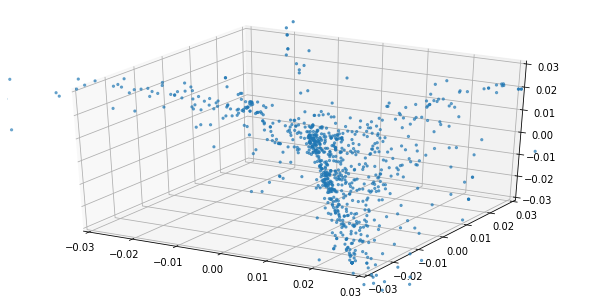

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(8,4))
ax = Axes3D(fig) 
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=5)

#xlim = ax.set_xlim3d([-150,150])
#ylim = ax.set_ylim3d([-150,150])
#zlim = ax.set_zlim3d([-150,150])
xlim = ax.set_xlim3d([-.03,.03])
ylim = ax.set_ylim3d([-.03,.03])
zlim = ax.set_zlim3d([-.03,.03])